In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from services.machine_service import MachineService
from services.experiment_service import ExperimentService

def elastic_correction(stress, disp, k):
    """
    Apply elastic correction to displacement data.

    Parameters:
    stress (np.ndarray): The stress data array.
    disp (np.ndarray): The displacement data array.
    k (float or np.ndarray): The stiffness value (scalar or array).

    Returns:
    np.ndarray: Elastic corrected displacement data.
    """
    # Convert scalar k to an array if it is not already an array
    if np.isscalar(k):
        k = np.full_like(stress[:-1], k)
    else:
        k = k[:-1]

    # Increments in elastic distortion
    dload = (stress[1:] - stress[:-1]) / k
    # Increments in total displacement
    ddisp = disp[1:] - disp[:-1]
    # Subtract elastic distortion from total displacement
    ec_disp = np.hstack([0, np.cumsum(ddisp - dload)])
    return ec_disp

machine_service = MachineService()
experiment_service = ExperimentService()

experiment_id = 's0144sa03min22'
machine_id = 'Brava2'
experiment_data = experiment_service.get_experiment_by_id(experiment_id)
experiment_date = experiment_data['Start_Datetime']
group_name = "ADC"
# Fetch the centralized measurements 
vertical_load_measurements = experiment_service.get_centralized_measurements(experiment_id=experiment_id, group_name=group_name, channel_name= 'Vertical Load')
horizontal_load_measurements = experiment_service.get_centralized_measurements(experiment_id, group_name=group_name, channel_name= 'Horizontal Load')
vertical_displacement_measurements = experiment_service.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Vertical Displacement')
horizontal_displacement_measurements = experiment_service.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Horizontal Displacement')
time_measurements = experiment_service.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Time')

Vertical_Load_recorded = np.array(vertical_load_measurements['data'])
Horizontal_Load_recorded = np.array(horizontal_load_measurements['data'])
Vertical_Displacement = np.array(vertical_displacement_measurements['data'])
Horizontal_Displacement = np.array(horizontal_displacement_measurements['data'])
time_s = np.array(time_measurements['data'])
records_na = np.arange(len(time_s))

# Fetch the properties for visualization scaling
vertical_visualization_scaling = vertical_load_measurements['properties']['Slope']
vertical_intercept = vertical_load_measurements['properties']['Intercept']
horizontal_visualization_scaling = horizontal_load_measurements['properties']['Slope']
horizontal_intercept = horizontal_load_measurements['properties']['Intercept']

vertical_load_voltage = Vertical_Load_recorded + vertical_intercept/vertical_visualization_scaling
horizontal_load_voltage = Horizontal_Load_recorded + horizontal_intercept/horizontal_visualization_scaling

vertical_load_kN = machine_service.apply_calibration(machine_id, 'vertical', vertical_load_voltage, experiment_date)
horizontal_load_kN = machine_service.apply_calibration(machine_id, 'horizontal', horizontal_load_voltage, experiment_date)

# This information can be retrieved from the lateral block sizes: gouge area is just x*y dimensions
gouge_area = 0.0025 # m^2. It can be retrieved from the dimensions of the blocks
conversion_parameter = 1e3 * gouge_area # from kN to MPa, so from force to stress

#### Vertical stress ###
#### This is the point at which the ram contacted the blocks and load shear loading began
#### So far it is chosen looking at the plot, but it must be automatize too
beg_row_v = 2808
##################################

# ZERO DATA
# add in force from the central block due to gravity
# v_load = v_load + 0.044 #[kN]
# remove noise before load is applied
vertical_load_kN = vertical_load_kN - vertical_load_kN[beg_row_v]
vertical_load_kN[:beg_row_v]= vertical_load_kN[:beg_row_v]*0
# calculate stress for DDS 5x5
shear_stress_MPa = vertical_load_kN/(2*conversion_parameter)      # why that "2" Lo sforzo di taglio va suddiviso sui due gouges, non cosi quello normale!!!

# Note:  
# 1. These values are calculated for a 5x5[cm] shear surface  
# 2. Stiffness is non linear at low applied loads  
# TO DO: implement a function that corrects for non-linear stiffness: this has been done by Pignalberi
# Here the vertical force is zeroed 
vertical_force = np.where(vertical_load_kN > 0, vertical_load_kN, 0)
#### vertical disp ####
load_point_disp = Vertical_Displacement - Vertical_Displacement[beg_row_v] # [mum]
load_point_disp[:beg_row_v] = load_point_disp[:beg_row_v]*0
load_point_disp_mm = load_point_disp/1000       # [mm]

# Elastic correction for the stretch of the vertical frame # 
vertical_k_constant = 166.801 #[MPa/mm]         # calibration from loading and unloading cycles on steel: linear approx
vertical_k = machine_service.apply_stiffness_correction(machine_id, 'vertical', vertical_load_kN, experiment_date)

# "Elastic corrected" displacement
ec_disp_mm = elastic_correction(vertical_load_kN, load_point_disp_mm, vertical_k) 
ec_disp_mm_old = elastic_correction(shear_stress_MPa, load_point_disp_mm, vertical_k_constant)

#############  normal load ############ 
#### Normal load is applied at record
beg_row_h = 234

######################################
# zero the data
horizontal_load_kN = horizontal_load_kN - horizontal_load_kN[beg_row_h]
# remove noise before load is applied 
horizontal_load_kN[:beg_row_h] = horizontal_load_kN[:beg_row_h]*0
# calculate stress for DDS 5x5
normal_stress_MPa =  horizontal_load_kN/(conversion_parameter)
#add a small number to normal stress 
#so that we aren't dividing by 0 anywhere to calculate mu 
epsilon = 1e-7
normal_stress_MPa = normal_stress_MPa + epsilon

# Note:  
# 1. These values are calculated for a 5x5[cm] shear surface  
# 2. Stiffness is non linear at low applied loads  
# TO DO: implement a function that corrects for non-linear stiffness. Pignalberi has done it
horizontal_force = np.where(vertical_load_kN > 0, vertical_load_kN, 0)

# Elastic correction for the stretch of the horizontal frame #
horizontal_k_constant = 125.363 #[MPa/mm]              # calibration from loading and unloading cycles on steel: linear approx
horizontal_k = machine_service.apply_stiffness_correction(machine_id, 'horizontal', horizontal_load_kN, experiment_date)

# Carolina, correzione iniziale serve nel caso carico normale variabile e se necessario valore assoluto layer thickNess (tipo, fase iniziale)
horizontal_displacement_corrected_mm = elastic_correction(horizontal_load_kN, -Horizontal_Displacement/1000,horizontal_k)   # why "-"? So that compaction is negative
horizontal_displacement_corrected_mm_old = elastic_correction(normal_stress_MPa, -Horizontal_Displacement/1000,horizontal_k_constant)

######################################################################
########## 5. Calculate layer thickNess: MUST STANDARDIZE!!! ##########################
##################################################################### 
# insert rec number at which layer thickness was measured
rec_lt = 234
# insert calculated value at that point
val_lt = 6    # [mm]
# ###########################################################
# zero data
layer_thickness_corrected_mm = horizontal_displacement_corrected_mm - horizontal_displacement_corrected_mm[rec_lt]
layer_thickness_corrected_mm_half = layer_thickness_corrected_mm/2
layer_thickness_corrected_mm1 = layer_thickness_corrected_mm_half + val_lt

layer_thickness_corrected_mm_old = horizontal_displacement_corrected_mm_old - horizontal_displacement_corrected_mm_old[rec_lt]
layer_thickness_corrected_mm_old_half = layer_thickness_corrected_mm_old/2
layer_thickness_corrected_mm_old1 = layer_thickness_corrected_mm_old_half + val_lt

# # default unit is [mm]
# rgt_lt_mm = rp.rgt(load_point_disp_mm,layer_thickness_corrected_mm1)     # remove geometrical thinning
# # 6. Calculate friction 
friction_na = shear_stress_MPa / normal_stress_MPa

# # 7. Calculate shear strain. Marco dice indifferente lt o quella corretta per geometrical thinning
# shear_strain_na = rp.shear_strain(ec_disp_mm,layer_thickness_corrected_mm1)


MongoDB is running.
MongoDB is running.
Experiment s0144sa03min22 found
Applied calibration for piston vertical in machine Brava2.
Applied calibration for piston horizontal in machine Brava2.
Applied stiffness correction for piston vertical in machine Brava2.
Applied stiffness correction for piston horizontal in machine Brava2.


NameError: name 'rp' is not defined

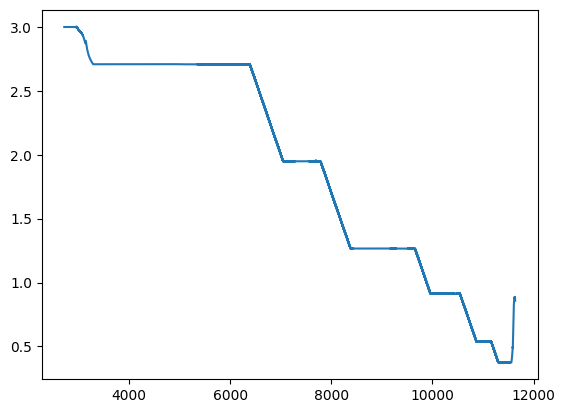

In [12]:
plt.plot(time_s,layer_thickness_corrected_mm + 3)